In [295]:
import torch
import numpy as np
# from skimage import io, transform
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import os
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import re
import unicodedata # ??
import nltk
from nltk.tokenize import TweetTokenizer
import csv
import json
np.random.seed(1)
random.seed(1)


# define directory structure needed for data processing
RAW_DATA_DIR = os.path.join('..', 'data/', 'raw_data/')
FORMAL_DATA_DIR = os.path.join('..', 'data/', 'formal_data/')
UNKNOWN_TOKEN = "unk"

## Split data into `train`, `val` and `test`
Split and write raw data as `acsii` format. 

In [208]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )
def normalizeString(s):
    s = unicodeToAscii(s.strip()).replace("\t", "")
    return s


# precondition: two fields with name: "headline" and "text"
def splitData(fname, test_size=0.2, val_size=0.2): 
    df = pd.read_csv('../data/' + fname, encoding='latin-1')
    df = df[["headline", "text"]] # summary text, not the entire article
    df["headline"] = df["headline"].apply(normalizeString)
    df["text"] = df["text"].apply(normalizeString)

    df = df.sample(frac=1).reset_index(drop=True) # shuffle data

    df_train, df_test = train_test_split(df, test_size=test_size, random_state=1)
    df_train, df_val = train_test_split(df_train, test_size=val_size, random_state=1)
    df_train.to_csv(RAW_DATA_DIR + "train.csv", index=False, sep="\t")
    df_val.to_csv(RAW_DATA_DIR + "val.csv", index=False, sep="\t")
    df_test.to_csv(RAW_DATA_DIR + "test.csv", index=False, sep="\t")
    
# # TODO: check whether "text" is in fact the summary and corresponds to the headline

splitData("news_summary.csv")

## Preprocess `raw_data` to `formal_data`

In [297]:
# class to store string transformation
class Transform(object):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    @staticmethod
    def word_tokenize(s): 
        return json.dumps(Transform.tokenizer.tokenize(s))
    
    @staticmethod
    def cap(s): 
        return s.upper()
    
# tf: a transformation apply to each individual headline and text
# Apply a transformation to the dataframe in "raw_data" 
# Results of the transformation is in "formal_data"
def preprocess(fname, tf, chunksize=1000, num_chunk=-1): 
    header = True
    mode = "w"
    i = 0
    for df in pd.read_csv(RAW_DATA_DIR + fname, sep="\t", header = 0, chunksize=chunksize):
        df["headlines"] = df["headlines"].apply(tf)
        df["text"] = df["text"].apply(tf)
        df.to_csv(FORMAL_DATA_DIR+fname, columns = ['headlines','text'], mode=mode,index=False, header=header, sep="\t")
        if header == True:  
            # no header, and write in append mode from the 2nd chunk
            header = False; 
            mode = "a"
        
        i = i + 1 if i >= 0 else -1
        if i == num_chunk: 
            break; 

preprocess("train.csv", tf=Transform.word_tokenize)
preprocess("val.csv", tf=Transform.word_tokenize)
preprocess("test.csv", tf=Transform.word_tokenize)

[]

## Build up language model using train data

In [348]:
SOS_token = 0 # start of sentence
EOS_token = 1 # end of sentence

# Modified from: Sean Robertson <https://github.com/spro/practical-pytorch>
class Lang: # language model
    def __init__(self, fname=None):
        self.word2index = {"SOS": 0, "EOS": 1}
        self.word2count = {"SOS": 1, "EOS": 1}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.size = 2  # Count SOS and EOS  
        if fname is not None: 
            self.addCSV(fname)

    # add words of a sentence into the language model
    # split by ' '
    def addSentence(self, sentence):
        for word in sentence: 
            self.addWord(word)

    # add a word to language model
    def addWord(self, word):
        if word not in self.word2index:
            # assign id for word
            self.word2index[word] = self.size
            
            # count word
            self.word2count[word] = 1
            
            self.index2word[self.size] = word
            self.size += 1
        else:
            self.word2count[word] += 1
            
    def addDataFrame(self, df): 
        # df: headline, text
        for index, row in df.iterrows():
            self.addSentence(json.loads(row['headlines']))
            self.addSentence(json.loads(row['text']))
            
    def addCSV(self, fname): 
        # construct language model based on a file
        # file is a dataframe csv file with "headlines" and "text"
        for df in pd.read_csv(FORMAL_DATA_DIR + fname, sep="\t", header = 0, chunksize=2000):
            self.addDataFrame(df)     
    
    def size(self): 
        return len(self.word2index)
    
#     lang.addDataFrame(df)
# def readLangs():
#     print("Reading lines...")

#     # each line as an element in a list
#     lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
#         read().strip().split('\n')

#     # Split every line into pairs and normalize
#     pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

#     # build the two language model based on the data file

#     lang = Lang()
#     print("Done reading")
#     return lang, pairs



In [349]:
lang = Lang("train.csv")
print(lang.size)
lang.word2index

18330


{'SOS': 0,
 'EOS': 1,
 'got': 2,
 'kicked': 3,
 'out': 4,
 'of': 5,
 'cbfc': 6,
 "chief's": 7,
 'office': 8,
 ',': 9,
 'claims': 10,
 'journalist': 11,
 'siddhant': 12,
 'adlakha': 13,
 'has': 14,
 'claimed': 15,
 'that': 16,
 'he': 17,
 '"': 18,
 'censor': 19,
 'board': 20,
 'chief': 21,
 'pahlaj': 22,
 "nihalani's": 23,
 'when': 24,
 'questioned': 25,
 'him': 26,
 'on': 27,
 'the': 28,
 'film': 29,
 'certification': 30,
 'process': 31,
 'during': 32,
 'an': 33,
 'interview': 34,
 '.': 35,
 'you': 36,
 '(': 37,
 'media': 38,
 ')': 39,
 'are': 40,
 'interfering': 41,
 'without': 42,
 'any': 43,
 'reason': 44,
 'in': 45,
 'our': 46,
 'business': 47,
 'said': 48,
 'nihalani': 49,
 'asked': 50,
 'if': 51,
 'curtails': 52,
 'rights': 53,
 'producers': 54,
 'as': 55,
 'artistes': 56,
 'to': 57,
 'leave': 58,
 'pnb': 59,
 'block': 60,
 'all': 61,
 'maestro': 62,
 'debit': 63,
 'cards': 64,
 'from': 65,
 'july': 66,
 '31': 67,
 'punjab': 68,
 'national': 69,
 'bank': 70,
 'card': 71,
 'holder

In [351]:
lang.word2index["work"]

539

In [242]:
DF

,headlines,text
0,"[got, kicked, out, of, cbfc, chief's, office, ...","[journalist, siddhant, adlakha, has, claimed, ..."
1,"[pnb, to, block, all, maestro, debit, cards, f...","[punjab, national, bank, (, pnb, ), maestro, d..."
2,"[maharashtra, first, state, to, enact, anti-so...","[president, pranab, mukherjee, on, thursday, g..."
3,"[free, ?, 10, lakh, insurance, for, buying, ra...","[all, railway, passengers, who, buy, tickets, ..."
4,"[udta, punjab, wasn't, made, with, aim, to, wi...","[actress, alia, bhatt, has, said, that, the, f..."
5,"[protestors, pelt, stones, at, police, outside...","[nearly, 500, protestors, pelted, stones, at, ..."
6,"[india, made, me, ,, freedom, fighter's, son, ...","[actor, shah, rukh, khan, ,, during, his, firs..."
7,"[lpg, cylinder, explosion, at, delhi, tea, sta...","[at, least, five, people, were, killed, and, n..."
8,"[kerala, bar, builds, maze, to, beat, liquor, ...","[a, bar, in, kerala, has, built, a, maze, arou..."
9,"[randeep, visits, war, memorial, ahead, of, ka...","[actor, randeep, hooda, visited, the, kargil, ..."


In [185]:
preprocess('train')

ValueError: DataFrame constructor not properly called!

In [ ]:


def preprocess(fname):
    raw_data = os.path.join(DATA_DIR, '%s.csv'%fname)
    tok_data = os.path.join(FORMAL_DATA_DIR, '%s_tok.csv'%fname)
    tmp_data = os.path.join(FORMAL_DATA_DIR, 'tmp.csv')
    
    # to keep track of our vocabulary
#     fq_dict = {}
#     def update_freq_dict(key):
#         if key not in fq_dict:
#             fq_dict[key] = 0
#         fq_dict[key] += 1
        
#     # since the labels for the dev data reside in a separate file, we need to pre-load it
#     if fname == 'dev':
#         dev_labels = []
#         with open(os.path.join(DATA_DIR, 'trial-v3.labels'), 'r') as flabels:
#             next(flabels) # skip header
#             for line in flabels:
#                 if line and len(line) > 0:
#                     dev_labels.append(line.strip())
    
    tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    
    # First we do one pass through the dataset, clean the tokens while maintaining 
    # a word frequency count by dumping everything to a tmp file
    with open(raw_data, 'r') as fin, open(tmp_data, 'w') as ftmp:
        csv_tmp = csv.writer(ftmp)
                
        # not using csv reader because of quoting and delimiter issues
        # which may lead to skipping rows or missing half of a row
        for i, line in enumerate(fin):   
            # skip header row
#             if i == 0:
#                 continue
                
#             # to handle the last empty line if any
#             line = line.rstrip('\n')
#             if not line or len(line) == 0:
#                 continue
                
#             # because we only have two columns, we manually split on the first comma,
#             # and remove double quotes at the ends if they exist
#             row = [item.strip('\"') for item in line.rstrip('\n').split(',', 1)]
#             label = dev_labels[i-1] if fname == 'dev' else row[0]
#             tweet = row[1]
                    
#             # get rid of components like url, hashtags, mentions and retweets
#             for reg in REGEXES:
#                 tweet = re.compile(reg).sub('', tweet)
            
            sentences = nltk.sent_tokenize(tweet)
            tweet_tokens = []
            for sentence in sentences:
                tokens = tweet_tokenizer.tokenize(sentence)
                for token in tokens:

                    token = token.strip(string.punctuation)
                    if token.lower() == 'newline':
                        continue
                    # remove unicode characters
                    token = token.encode('ascii', 'ignore').decode('utf-8') 
                    if len(token) > 0:
                        tweet_tokens.append(token)
#                             update_freq_dict(token)

            if len(tweet_tokens) > 0:
                csv_tmp.writerow([label, json.dumps(tweet_tokens)])
            elif fname == 'dev':
                csv_tmp.writerow([label, json.dumps([UNKNOWN_TOKEN])])
#                 update_freq_dict(UNKNOWN_TOKEN)

    # then for the training set, we change all low frequency words to 'UNKNOWN'
    with open(tmp_data, 'r') as ftmp, open(tok_data, 'w') as fout:
        csv_tmp = csv.reader(ftmp)
        csv_out = csv.writer(fout)
        
        for i, row in enumerate(csv_tmp):
            if not row or len(row) == 0: 
                break
            label = row[0].strip()
            tweet_tokens = json.loads(row[1].strip())
            
            filtered_tokens = []
            for token in tweet_tokens:
                if fname == 'train' and (fq_dict[token] < 2 and not token.startswith(':')):
                    filtered_tokens.append(UNKNOWN_TOKEN)
                else:
                    filtered_tokens.append(token)
            csv_out.writerow([label, json.dumps(filtered_tokens)])
              
    # clean up 
    os.remove(tmp_data)

In [150]:
df_train.to_csv("../data/train.csv", sep='\t', encoding='ascii')
df_val.to_csv("../data/val.csv", sep='\t', encoding='ascii')
df_test.to_csv("../data/test.csv", sep='\t', encoding='ascii')

In [109]:
lang = Lang()
[lang.addSentence(s) for s in X_train]; 
lang.word2index

{'India': 2,
 'offers': 3,
 'to': 4,
 'give': 5,
 'up': 6,
 'veto': 7,
 'power': 8,
 'temporarily': 9,
 'at': 10,
 'UNSC': 11,
 'Superwoman': 12,
 'tweets': 13,
 'Sushma': 14,
 'Swaraj': 15,
 'slam': 16,
 'visa': 17,
 'delay': 18,
 '44,000': 19,
 'toilets': 20,
 'must': 21,
 'be': 22,
 'built': 23,
 'daily': 24,
 'make': 25,
 'UP': 26,
 'ODF': 27,
 'by': 28,
 '2018': 29,
 'Bowlers': 30,
 'second-class': 31,
 'citizens': 32,
 'in': 33,
 'white-ball': 34,
 'cricket:': 35,
 'Bond': 36,
 'UK': 37,
 'replace': 38,
 '£1': 39,
 'coin': 40,
 'combat': 41,
 'counterfeiting': 42,
 '?10L': 43,
 'compensation': 44,
 'for': 45,
 'J&K': 46,
 'man': 47,
 'used': 48,
 'as': 49,
 'human': 50,
 'shield': 51,
 'Army': 52,
 'Delhi': 53,
 'Metro': 54,
 'line': 55,
 'halted': 56,
 'hours': 57,
 'bird': 58,
 'gets': 59,
 'electrocuted': 60,
 'Air': 61,
 "India's": 62,
 'missing': 63,
 'painting': 64,
 'arrives': 65,
 'head': 66,
 'office': 67,
 'explosion': 68,
 'suicide': 69,
 'bomber': 70,
 'died': 71,
 's

### Summary statisics

(array([   9.,   15.,   34.,   69.,  116.,  203.,  361.,  657., 1395.,
        1655.]),
 array([31. , 34.1, 37.2, 40.3, 43.4, 46.5, 49.6, 52.7, 55.8, 58.9, 62. ]),
 <a list of 10 Patch objects>)

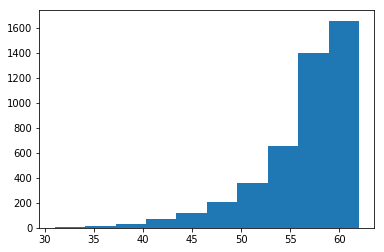

In [56]:
headline_length = df['headlines'].apply(len).values # character length not word length
plt.hist(headline_length)

(array([ 30.,  86., 194., 377., 534., 812., 851., 733., 495., 402.]),
 array([282. , 293.8, 305.6, 317.4, 329.2, 341. , 352.8, 364.6, 376.4,
        388.2, 400. ]),
 <a list of 10 Patch objects>)

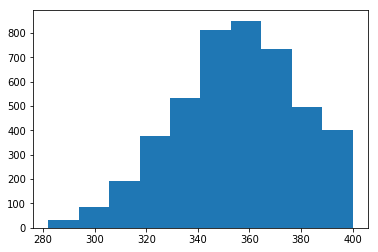

In [63]:
body_length = df['text'].apply(len).values # character length not word length
plt.hist(body_length)

In [43]:
df

,headlines,text
0,Molestation case against TVF CEO to be closed:...,Mumbai Police will reportedly close the probe ...
1,"Cong single largest party in Manipur, fails to...",Manipur on Saturday witnessed a hung Assembly ...
2,Qatar Airways plans airline in India,Qatar Airways is planning to set up an airline...
3,US to suspend covert CIA program in Syria: Rep...,US President Donald Trump has reportedly decid...
4,"5 liquor smugglers, 3 drug peddlers arrested i...",The Ghaziabad Police on Sunday said they have ...
5,There is a void after Kumble's exit: India bat...,India's batting coach Sanjay Bangar has said t...
6,Police save woman attempting to live-stream he...,A 32-year-old woman lawyer in Mumbai reportedl...
7,World's cheapest phone Freedom 251 maker's MD ...,"Noida-based company, which claims its phone Fr..."
8,Haryana seeks 5k paramilitary personnel over J...,The Haryana government has sought from the Cen...
9,In govt interest to protect jobs at Air India:...,Finance Minister Arun Jaitley has said that a ...


pandas.core.frame.DataFrame

In [19]:
body[200]

"Congress on Monday informed Rajya Sabha that Raj Babbar has been injured in police action against villagers protesting demolition of their houses in Uttar Pradesh. They added that due to the injuries, he was unable to attend the Parliament proceedings. The house's Deputy Chairman dismissed the issue of Babbar's safety and security saying the state government should deal with this."